In [7]:
import pandas as pd
import numpy as np
from datetime import datetime
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

# --- A. Setup ---
# Set pandas options for better display
pd.set_option('display.max_columns', None)
print("Libraries loaded successfully.")

# --- B. Simulated Data Loading ---
# NOTE: Replace these with your actual data loading mechanism (e.g., pd.read_csv('nsclc.csv'))
data_path = './data/' 
# Example file names assumed: 'nsclc.csv', 'mortality.csv', etc.

# Load primary tables
df_nsclc = pd.read_csv(f'FI_NSCLC/FI_NSCLC/nscexpnd_nsclc_2506.csv')
df_mortality = pd.read_csv(f'FI_NSCLC/FI_NSCLC/nscexpnd_mortality_v2_2506.csv')
df_demographics = pd.read_csv(f'FI_NSCLC/FI_NSCLC/nscexpnd_demographics_2506.csv')
df_ecog = pd.read_csv(f'FI_NSCLC/FI_NSCLC/nscexpnd_ecog_2506.csv')
df_biomarkers = pd.read_csv(f'FI_NSCLC/FI_NSCLC/nscexpnd_nsclcbiomarkers_2506.csv')
df_vitals = pd.read_csv(f'FI_NSCLC/FI_NSCLC/nscexpnd_vitals_2506.csv')
df_visits = pd.read_csv(f'FI_NSCLC/FI_NSCLC/nscexpnd_visit_2506.csv')
df_lot = pd.read_csv(f'FI_NSCLC/FI_NSCLC/nscexpnd_nsclclot_2506.csv')

print("\nAll required datasets simulated/loaded.")

Libraries loaded successfully.

All required datasets simulated/loaded.


In [2]:
cohort = df_nsclc[df_nsclc["isnsclc"] == 1].copy()

In [3]:
cohort["start_date"] = pd.to_datetime(cohort["nsclcdiagnosisdate"])

In [4]:
mort = df_mortality[["patientid", "dateofdeath"]].copy()
mort["dateofdeath"] = pd.to_datetime(mort["dateofdeath"])

cohort = cohort.merge(mort, on="patientid", how="left")

cohort["event"] = cohort["dateofdeath"].notna().astype(int)

In [8]:
last_visit = (
    df_visits.groupby("patientid")["visitdate"]
    .max()
    .reset_index()
)

last_visit["visitdate"] = pd.to_datetime(last_visit["visitdate"])
cohort = cohort.merge(last_visit, on="patientid", how="left")

In [9]:
DATA_CUTOFF = pd.to_datetime("2025-01-01")

cohort["end_date"] = cohort["dateofdeath"]

cohort.loc[
    cohort["event"] == 0, "end_date"
] = cohort.loc[
    cohort["event"] == 0, "visitdate"
]

cohort["end_date"] = cohort["end_date"].fillna(DATA_CUTOFF)

In [10]:
cohort["os_time_days"] = (
    cohort["end_date"] - cohort["start_date"]
).dt.days

In [13]:
cohort = cohort.copy()  # forces pandas to refresh column references

In [15]:
# Force numeric
cohort["os_time_days"] = pd.to_numeric(
    cohort["os_time_days"], errors="coerce"
)

# Drop invalid survival times
invalid_rows = cohort["os_time_days"].isna() | (cohort["os_time_days"] <= 0)

print(f"Dropping {invalid_rows.sum()} invalid OS rows")

cohort = cohort.loc[~invalid_rows].copy()


Dropping 61 invalid OS rows


In [16]:
cohort = cohort.merge(
    df_demographics[["patientid", "birthyear", "birthsex", "race"]],
    on="patientid",
    how="left"
)

cohort["age"] = cohort["start_date"].dt.year - cohort["birthyear"]

In [17]:
ecog = df_ecog.copy()
ecog["ecogdate"] = pd.to_datetime(ecog["ecogdate"])

ecog = ecog.merge(
    cohort[["patientid", "start_date"]],
    on="patientid",
    how="inner"
)

ecog = ecog[ecog["ecogdate"] <= ecog["start_date"]]

baseline_ecog = (
    ecog.sort_values("ecogdate")
        .groupby("patientid")
        .last()
        .reset_index()
)

cohort = cohort.merge(
    baseline_ecog[["patientid", "ecogvalue"]],
    on="patientid",
    how="left"
)


In [18]:
features = [
    "groupstage", "ismetastatic",
    "histology", "smokingstatus",
    "hassurgery"
]

# Already present in cohort


In [19]:
os_df = cohort[
    [
        "patientid",
        "os_time_days",
        "event",
        "age",
        "birthsex",
        "race",
        "ecogvalue",
        "groupstage",
        "ismetastatic",
        "histology",
        "smokingstatus",
        "hassurgery"
    ]
].copy()


In [20]:
# One row per patient
assert os_df["patientid"].is_unique

# No missing survival info
assert os_df["os_time_days"].notna().all()
assert os_df["event"].notna().all()

# Event distribution
print(os_df["event"].value_counts())


event
1    708
0    581
Name: count, dtype: int64


Handle missing values

In [21]:
os_df["ecogvalue"] = os_df["ecogvalue"].fillna(os_df["ecogvalue"].median())

Encode categorical variables

In [22]:
cat_cols = [
    "birthsex",
    "race",
    "groupstage",
    "histology",
    "smokingstatus"
]

os_df_encoded = pd.get_dummies(
    os_df,
    columns=cat_cols,
    drop_first=True   # avoid multicollinearity
)


Final modeling table

In [23]:
model_df = os_df_encoded.drop(columns=["patientid"])


In [26]:
model_df["hassurgery"] = model_df["hassurgery"].fillna(0).astype(int)

In [28]:
model_df["age"] = pd.to_numeric(model_df["age"], errors="coerce")
model_df["age"] = model_df["age"].fillna(model_df["age"].median())

In [29]:
model_df.isna().sum().sort_values(ascending=False)

os_time_days                             0
event                                    0
age                                      0
ecogvalue                                0
ismetastatic                             0
hassurgery                               0
birthsex_M                               0
race_Black or African American           0
race_Hispanic or Latino                  0
race_Other Race                          0
race_White                               0
groupstage_Stage I                       0
groupstage_Stage IA                      0
groupstage_Stage IB                      0
groupstage_Stage II                      0
groupstage_Stage IIA                     0
groupstage_Stage IIB                     0
groupstage_Stage III                     0
groupstage_Stage IIIA                    0
groupstage_Stage IIIB                    0
groupstage_Stage IIIC                    0
groupstage_Stage IV                      0
groupstage_Stage IVA                     0
groupstage_

FIT THE COX PROPORTIONAL HAZARDS MODEL

In [30]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()

cph.fit(
    model_df,
    duration_col="os_time_days",
    event_col="event"
)

<lifelines.CoxPHFitter: fitted with 1289 total observations, 581 right-censored observations>

In [31]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1289 total observations, 581 right-censored observations>
             duration col = 'os_time_days'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1289
number of events observed = 708
   partial log-likelihood = -4277.34
         time fit was run = 2025-12-16 05:53:42 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
age                                    0.02      1.02      0.00            0.01            0.03                1.01                1.03
ecogvalue                              0.14      1.15      0.11           -0.08            0.36                0.92                1.43
ismetastatic                           0.34      1.41      0.11            0.13            0.56                1.13                1.76
hassurgery                            -0.63      0.53      0.13           -0.88           -0.38                0.41                0.69
birthsex_M                             0.09      1.09      0.08           -0.07            0.24                0.93                1.28
race_Black or African American        -0.03      0.97      0.16           -0.36            0.29                0.70                1.34
race_Hispanic or Latino                0.63      1.87      0.73           -0.80            2.05                0.45                7.75
race_Other Race                        0.16      1.17      0.14           -0.12            0.44                0.88                1.56
race_White                            -0.19      0.83      0.10           -0.38            0.00                0.69                1.00
groupstage_Stage I                    -0.49      0.61      0.29           -1.05            0.07                0.35                1.07
groupstage_Stage IA                   -0.76      0.47      0.23           -1.20           -0.32                0.30                0.73
groupstage_Stage IB                   -0.37      0.69      0.25           -0.87            0.13                0.42                1.14
groupstage_Stage II                   -0.23      0.79      0.61           -1.43            0.96                0.24                2.61
groupstage_Stage IIA                  -0.41      0.66      0.32           -1.03            0.20                0.36                1.23
groupstage_Stage IIB                  -0.56      0.57      0.27           -1.10           -0.02                0.33                0.98
groupstage_Stage III                  -0.78      0.46      0.45           -1.66            0.11                0.19                1.11
groupstage_Stage IIIA                 -0.18      0.84      0.21           -0.59            0.24                0.55                1.27
groupstage_Stage IIIB                  0.01      1.01      0.22           -0.43            0.45                0.65                1.57
groupstage_Stage IIIC                  0.50      1.65      0.40           -0.28            1.28                0.75                3.60
groupstage_Stage IV                    0.33      1.38      0.21           -0.09            0.74                0.92                2.09
groupstage_Stage IVA                  -0.28      0.75      0.27           -0.81            0.25                0.44                1.28
groupstage_Stage IVB                   0.53      1.70      0.27           -0.00            1.07                1.00                2.90
histology_Non-squamous cell carcinoma -0.13      0.88      0.21           -0.55            0.29                0.58                1.34
histology_Squamous cell carcinoma      0.25      1.28      0.22           -0.18            0.68                0.84                1.97
smokingstatus_No history of smoking   -0.31      0.73      0.14           -0.58           -0.04 

In [32]:
cph.concordance_index_

np.float64(0.721822820273195)

In [33]:
cph.check_assumptions(
    model_df,
    p_value_threshold=0.05
)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1289 total observations, 581 right-censored observations>
         test_name = proportional_hazard_test

---
                                            test_statistic      p  -log2(p)
age                                   km              1.46   0.23      2.14
                                      rank            1.27   0.26      1.95
birthsex_M                            km              0.63   0.43      1.22
                                      rank            0.64   0.42      1.24
ecogvalue                             km              1.78   0.18      2.46
                                      rank            1.94   0.16      2.61
groupstage_Stage I                    km              0.61   0.44      1.20
                                      rank            0.84   0.36      1.47
groupstage_Stage IA                   km              4.02   0.04      4.48
                                      rank            3.75   0.05      4.24
groupstage_Stage IB                   km              0.82   0.37      1.45
                                      rank            0.88   0.35      1.53
groupstage_Stage II                   km              0.03   0.86      0.22
                                      rank            0.02   0.89      0.17
groupstage_Stage IIA                  km              0.06   0.81      0.31
                                      rank            0.11   0.74      0.44
groupstage_Stage IIB                  km              1.37   0.24      2.05
                                      rank            1.69   0.19      2.37
groupstage_Stage III                  km              0.02   0.88      0.19
                                      rank            0.00   0.99      0.02
groupstage_Stage IIIA                 km              0.01   0.90      0.14
                                      rank            0.00   0.95      0.07
groupstage_Stage IIIB                 km              0.04   0.85      0.23
                                      rank            0.01   0.93      0.11
groupstage_Stage IIIC                 km              0.03   0.87      0.20
                                      rank            0.01   0.93      0.10
groupstage_Stage IV                   km              4.51   0.03      4.89
                                      rank            4.37   0.04      4.77
groupstage_Stage IVA                  km              0.14   0.71      0.49
                                      rank            0.13   0.72      0.47
groupstage_Stage IVB                  km              1.10   0.29      1.77
                                      rank            1.22   0.27      1.89
hassurgery                            km              0.00   0.98      0.03
                                      rank            0.02   0.89      0.18
histology_Non-squamous cell carcinoma km              0.16   0.69      0.53
                                      rank            0.17   0.68      0.55
histology_Squamous cell carcinoma     km              2.84   0.09      3.44
                                      rank            3.31   0.07      3.86
ismetastatic                          km             12.88 <0.005     11.55
                                      rank           14.65 <0.005     12.91
race_Black or African American        km              0.08   0.78      0.35
                                      rank            0.12   0.73      0.46
race_Hispanic or Latino               km              1.12   0.29      1.78
                                      rank            0.82   0.36      1.46
race_Other Race                       km              0.56   0.45      1.14
                                      rank            0.64   0.42      1.24
race_White                            km              0.99   0.32      1.65
                                      rank            1.02   0.31      1.6



1. Variable 'ismetastatic' failed the non-proportional test: p-value is 0.0001.

   Advice: with so few unique values (only 2), you can include `strata=['ismetastatic', ...]` in the
call in `.fit`. See documentation in link [E] below.

2. Variable 'groupstage_Stage IA' failed the non-proportional test: p-value is 0.0449.

   Advice: with so few unique values (only 2), you can include `strata=['groupstage_Stage IA', ...]`
in the call in `.fit`. See documentation in link [E] below.

3. Variable 'groupstage_Stage IV' failed the non-proportional test: p-value is 0.0337.

   Advice: with so few unique values (only 2), you can include `strata=['groupstage_Stage IV', ...]`
in the call in `.fit`. See documentation in link [E] below.

4. Variable 'smokingstatus_No history of smoking' failed the non-proportional test: p-value is 0.0061.

   Advice: with so few unique values (only 2), you can include `strata=['smokingstatus_No history of
smoking', ...]` in the call in `.fit`. See documentation 

[]

<Axes: >

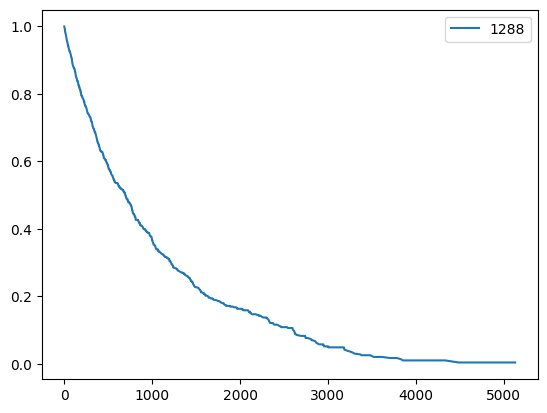

In [40]:
patient_example = model_df.drop(
    columns=["os_time_days", "event"]
).iloc[[1288]]

surv_curve = cph.predict_survival_function(patient_example)
surv_curve.plot()

In [41]:
cph.predict_median(patient_example)

np.float64(695.0)